In [1]:
import sys
import argparse
import pandas as pd
import os
import json
import torch
import sys
import joblib
import numpy as np
from collections import namedtuple

path_model = '../model'
path_data = '../data/input_create_model/processed' # path to data
path_train_files = f'{path_model}/output/5303fd9c/' # path to the trained toy model
path_save = './output/transcript_expression'
sys.path.append(path_model)

from utils.Utils import get_data, do_predictions #generate_data, scale_inputs_real_knockout_explainability, evaluate_model, get_significant_samples
from utils.Plots import plot_boxplot_with_annotations
from utils.Config import Config
from DLModelClass.modelsNN import DeepRBP

/opt/anaconda3/envs/DeepRBP/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tutorial 1: Predict transcript expression using a trained DeepRBP model and visualize results

## 1. Get and process the test data¶

### 1.1. Load the config used in training DeepRBP
We will load the configuration settings used during the training of DeepRBP and in this tutorial we will make predictions for liver tissue.

In [12]:
with open(f'{path_train_files}/config.json', 'r') as file:
    config_dict = json.load(file)
config_dict['test_tumor_types'] = 'Liver_Hepatocellular_Carcinoma'
config = Config(**config_dict)
print(config.get_config())

{'max_node': 1024, 'num_hidden_layers': 2, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'same_num_nodes': False, 'node_divition_factor': 4, 'activation_layer': 'relu', 'optimizer': 'adamW', 'source_train': 'TCGA', 'train_tumor_types': 'all', 'test_tumor_types': 'Liver_Hepatocellular_Carcinoma'}


### 1.2 Get test raw data
We are going to read the raw test data from both TCGA and GTEx.

In [14]:
data_test = get_data(config, path_data, set_mode='test')

[Utils][get_data] set_mode is test
[Utils][get_data] We are not selecting all the tumor types
['Liver_Hepatocellular_Carcinoma']
[Utils][get_data] path_raw:  ../data/input_create_model/processed/splitted_datasets/TCGA/test/Liver_Hepatocellular_Carcinoma
[Utils][get_data] tumor_type & source columns added to this set ... -> DONE
[Utils][get_data] path_raw:  ../data/input_create_model/processed/splitted_datasets/GTEX/test/Liver
[Utils][get_data] tumor_type & source columns added to this set ... -> DONE


Let's take a closer look at the data stored in the `data_test` variable:

* `df_raw`: these contain the raw test data with RBP expression in *log2(TPM+1)*, with dimensions *num_samples x n_rbps*.
* `raw_labels`: these hold the raw test data with transcript expression in *log2(TPM+1)*, with dimensions *num_samples x n_transcripts*.
* `raw_gn`: these store the raw test data with gene expression in *TPM* for each transcript, with dimensions *num_samples x n_transcripts*.

Therefore, if you want to introduce different data instead of TCGA, it should have the format mentioned here.

In [4]:
data_test.df_raw.head()

,A1CF,AATF,ABCF1,ABT1,ACAA2,ACIN1,ACTB,ACTN1,ACTN4,ADAR,...,ZNF638,ZNF768,ZNFX1,ZNHIT6,ZRANB2,ZRSR1,ZRSR2,ZYX,source,tumor_type
TCGA-56-7822-01,0.0,4.585610,5.526707,3.527348,3.935419,5.418205,11.993553,7.176895,9.756068,5.882637,...,5.435006,3.947667,4.472526,2.625234,4.356148,0.163501,3.085801,7.410795,TCGA,Lung_Squamous_Cell_Carcinoma
TCGA-85-A511-01,0.0,5.409026,5.508121,4.247923,4.080696,6.509408,11.894879,6.851733,7.768027,6.680223,...,5.986610,5.016140,3.726785,3.130893,4.956966,0.000000,3.206359,6.921340,TCGA,Lung_Squamous_Cell_Carcinoma
TCGA-43-6647-01,0.0,4.933067,5.877722,3.550930,4.863962,5.362075,12.172612,8.383622,9.477623,6.402736,...,4.737658,4.598742,3.807401,2.976346,3.972653,0.000000,3.313213,7.643924,TCGA,Lung_Squamous_Cell_Carcinoma
TCGA-98-A53H-01,0.0,5.051333,5.302295,3.890415,5.008969,6.280362,11.939667,7.130622,7.662332,6.276513,...,5.629903,4.574686,4.034730,3.158658,5.118107,0.475073,4.078908,7.429684,TCGA,Lung_Squamous_Cell_Carcinoma
TCGA-NC-A5HM-01,0.0,5.767699,5.597870,4.529209,5.098492,6.404119,12.352676,7.514007,7.445492,5.865927,...,6.313931,5.322670,4.226520,3.528535,4.612360,0.056585,3.864971,6.263780,TCGA,Lung_Squamous_Cell_Carcinoma


The last two columns assign the source of the samples (in this case, TCGA or GTEx) and the tumor type they come from.

In [5]:
data_test.raw_labels.head()

,ENST00000006015,ENST00000006750,ENST00000009530,ENST00000027335,ENST00000034275,ENST00000052569,ENST00000053243,ENST00000066544,ENST00000074304,ENST00000078429,...,ENST00000631199,ENST00000631253,ENST00000631589,ENST00000631641,ENST00000631857,ENST00000632133,ENST00000632375,ENST00000633063,ENST00000633317,ENST00000633691
TCGA-56-7822-01,0.505893,0.485434,7.347875,0.555816,2.070372,4.479593,0.545956,3.255507,2.528578,4.153829,...,0.000000,0.454178,0.000000,0.641556,0.773987,0.565594,0.0,2.700445,0.250954,0.713697
TCGA-85-A511-01,0.495692,2.094212,7.020246,0.042644,3.801180,3.273517,3.039140,3.956086,2.675856,4.338461,...,0.000000,0.056585,0.298665,0.000000,0.378503,1.608791,0.0,3.471190,0.000000,0.000000
TCGA-43-6647-01,0.378503,1.918383,8.225324,0.641556,3.802201,3.642672,2.912646,3.572900,2.147284,4.739295,...,0.028568,0.000000,0.000000,3.655373,0.575314,0.948623,0.0,2.333414,0.150557,0.176318
TCGA-98-A53H-01,0.536053,3.970874,8.850426,0.214120,3.229568,3.294248,2.584949,3.611145,2.901118,5.041732,...,0.000000,0.056585,0.000000,0.000000,0.056585,1.744179,0.0,2.794931,0.263040,0.000000
TCGA-NC-A5HM-01,0.000000,0.918387,5.727364,0.028568,1.056601,3.549650,1.244871,3.859942,1.541001,3.626395,...,0.000000,0.028568,0.000000,0.000000,0.226513,1.422221,0.0,2.516021,0.000000,0.070387


In [6]:
data_test.raw_gn.head()

,ENST00000006015,ENST00000006750,ENST00000009530,ENST00000027335,ENST00000034275,ENST00000052569,ENST00000053243,ENST00000066544,ENST00000074304,ENST00000078429,...,ENST00000631199,ENST00000631253,ENST00000631589,ENST00000631641,ENST00000631857,ENST00000632133,ENST00000632375,ENST00000633063,ENST00000633317,ENST00000633691
TCGA-56-7822-01,0.430012,1.709953,1117.530669,0.649987,28.420287,24.089626,0.459988,27.879799,7.800221,26.399622,...,21.309610,83.267562,14.490148,127.132463,9.859768,6175.754835,3.169917,8.030113,3.169917,96.803352
TCGA-85-A511-01,0.609981,10.560186,1063.569536,0.030000,55.000536,16.230225,7.469993,28.030946,6.930175,22.059598,...,19.450372,81.888127,12.220081,53.909710,39.409277,8804.954516,4.839983,20.210437,4.839983,79.301805
TCGA-43-6647-01,0.349990,8.729716,2292.171652,0.860009,39.128913,11.659842,7.009902,31.320904,7.430225,38.440694,...,15.359998,28.859012,6.729903,107.216753,25.419139,6523.813295,5.600060,5.799993,5.600060,71.208608
TCGA-98-A53H-01,0.450000,38.101137,3966.634179,0.200005,37.090070,12.849922,5.079956,19.299951,8.709768,36.650491,...,1.179993,30.260257,11.569666,85.959383,10.500329,9423.843379,12.930341,12.199768,12.930341,56.468502
TCGA-NC-A5HM-01,0.070002,2.350041,1169.599404,0.070002,26.229984,13.050104,1.750025,32.299845,2.739996,13.409583,...,0.949989,35.009118,9.790297,45.379481,6.250056,8336.926073,5.010005,13.710362,5.010005,150.914795


### 1.3. Get the scaler used in training

In [7]:
scaler_sfs = joblib.load(path_train_files+'/scaler_sfs.joblib')
with open(path_train_files+'/sigma_sfs.txt', 'r') as f:
    sigma_sfs = f.readline().strip()
sigma_sfs = np.float128(sigma_sfs)
Data_Scale = namedtuple('Data_Scale', ['scaler_sfs', 'sigma_sfs'])
data_scale = Data_Scale(scaler_sfs, sigma_sfs)

## 2. Load the trained model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DeepRBP(config=config)
model.load_state_dict(torch.load(f'{path_train_files}/model.pt', map_location=device))      
model.eval()

You are using a model with 2 hidden layers


DeepRBP(
  (linear0): Linear(in_features=1282, out_features=1024, bias=True)
  (bn0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a_function0): ReLU()
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a_function1): ReLU()
  (final_layer): Linear(in_features=256, out_features=11459, bias=True)
)

## 3. Make predictions in TCGA and GTeX

In [16]:
# This is a problem of the example I put, remove this in last version
# Columnas a eliminar
columns_to_remove = ['ENST00000413683', 'ENST00000540385', 'ENST00000593731']
# Eliminar columnas del DataFrame data_test.raw_gn
data_test.raw_gn.drop(columns=columns_to_remove, inplace=True)
# Eliminar columnas del DataFrame data_test.raw_labels
data_test.raw_labels.drop(columns=columns_to_remove, inplace=True)

For each tumor type in TCGA (or in GTEx), we scale the RBP expression data, make predictions using the trained model,
and evaluate the model's performance by calculating the MSE and Spearman's correlation. Additionally, plots with the results are provided.


[utils][do_predictions] Get Test Data to do the predictions ... -> DONE
[utils][do_predictions] Selected source to make the predictions: ['TCGA']
[utils][do_predictions] Select just the samples of the desired source and remove column source... -> DONE
[utils][do_predictions] Calculating predictions for Liver_Hepatocellular_Carcinoma tumor type
[utils][do_predictions] Shape of Liver_Hepatocellular_Carcinoma tumor type test data
rbp test data: (336, 1282)
test label data: (336, 11459)
test_gn data: (336, 11459)
[utils][get_scaled_rbp_test_data] Scale test data with the scaler used in Training ... -> DONE 
[utils][do_predictions] Scale Data of Liver_Hepatocellular_Carcinoma tumor type test data... -> DONE
pred: [0.         0.33455208 4.919771   ... 1.1302536  0.07191271 0.2088544 ]
labels: [0.         0.         4.90734423 ... 1.70489902 0.09761326 0.        ]
[utils][do_predictions] Calculate the total Spearman Correlation and the Pearson Correlation of Liver_Hepatocellular_Carcinoma tum

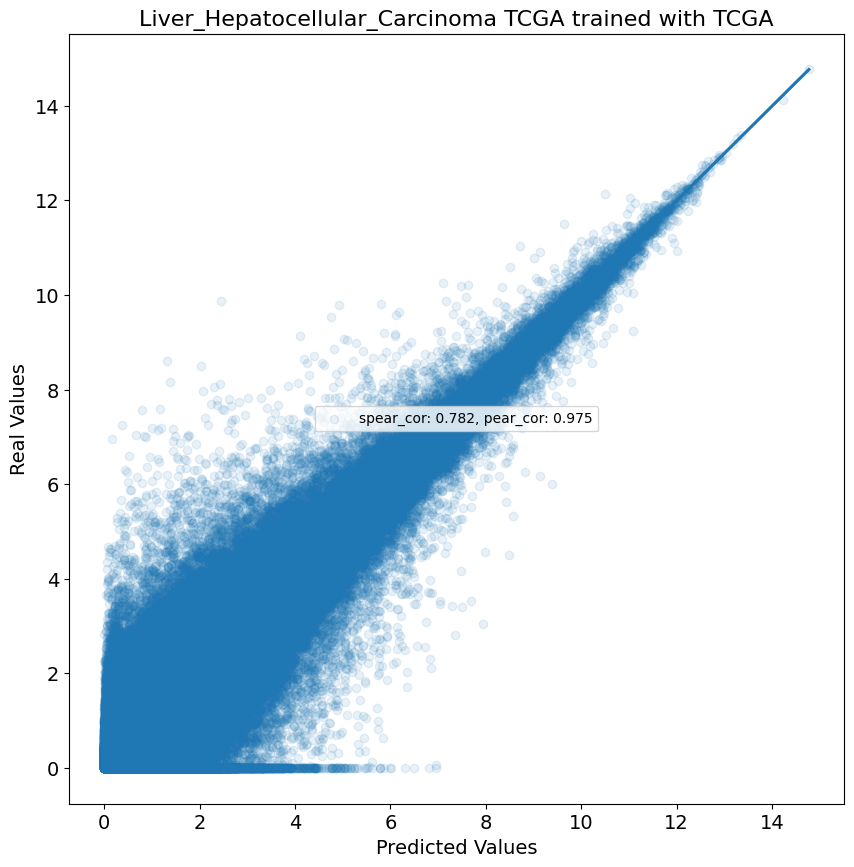

FileNotFoundError: [Errno 2] No such file or directory: '../data/input_create_model/processed../extra/getBM_reduced.csv'

In [17]:
results_tcga = do_predictions(
                            config=config, 
                            data_test=data_test, 
                            data_scale=data_scale, 
                            model=model, 
                            device=device, 
                            path_save=path_save, 
                            plot_results=True, 
                            pred_source = 'TCGA',
                            path_getBM = path_data +'../extra/getBM_reduced.csv')

In [ ]:
results_gtex = utils.do_predictions(
                                    config=config, 
                                    data_test=data_test, 
                                    data_scale=data_scale, 
                                    model=model, 
                                    device=device, 
                                    path_save=path_save, 
                                    plot_results=True, 
                                    pred_source = 'GTEX', 
                                    path_getBM = path_data +'../extra/getBM_reduced.csv')